In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import gym
import tensorflow as tf
from tensorflow import keras
np.random.seed(0)
tf.random.set_seed(0)
%matplotlib notebook

class Chart:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1)
    
    def plot(self, episode_rewards):
        self.ax.clear()
        self.ax.plot(episode_rewards)
        self.ax.set_xlabel('iteration')
        self.ax.set_ylabel('episode reward')
        self.fig.canvas.draw()

# 执行者/评论者方法

本章介绍**带自益的策略梯度方法** 。此类算法将策略梯度和自益结合：

- 一方面，**用一个含参函数近似价值函数** ，然后用此价值函数的近似值估计回报值；

- 另一方面，利用**估计得到的回报值估计策略梯度** ，进而更新参数。

这两方面被称为**评论者** （critic）和**执行者** （actor）。所以带自益的策略梯度算法被称为执行者/评论者算法。

**使用环境**：双节倒立摆

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)

[0]

## 同策执行者/评论者算法

执行者/评论者方法同样采用含参函数$h(s, a; \theta) $表示偏好，用其softmax运算的结果$\pi(s|a;\theta)$来近似最优策略。

在更新参数$\theta$时，执行者/评论者方法依然依据策略梯度定理，取$E[\Psi_t\nabla \ln\pi(A_t|S_t;\theta)]$​为梯度方向进行迭代更新。其中，$\Psi_t = \gamma^t (G_t - B(s))$。$\Psi_t$也可是以下形式：

* 动作价值：$\Psi_t = \gamma^t q_\pi(S_t,A_t)$
* 优势函数：$\Psi_t = \gamma^t[q_\pi(S_t,A_t) - v_\pi(S_t)]$
* 时序差分：$\Psi_t = \gamma^t [R_{t+1} + \gamma v_\pi(S_{t+1}) - v_\pi(S_{t})]$

在以上形式中，往往用价值函数估计回报，以上三种表示方式分别用$q_\pi(S_t,A_t), q_\pi(S_t,A_t), R_t + \gamma v_\pi(S_{t+1})$表示回报，后两者减去了基线以减小方差。

在实际使用中，价值是不知道的。可以采取一定手段进行估计。可以用函数近似的方法，用含参函数$v(s;\bold{w})$或$q(s,a;\bold{w})$来近似$v_\pi$和$q_\pi$。

上一章中，带基线的简单策略梯度算法已经使用了含参函数$v(s;\bold{w})$作为基线函数。我们可以在此基础上进一步引入自益的思想，用价值的估计$U_t$代替$\Psi_t$表示回报部分。

> 只用采用了自益的方法，即用价值估计来估计回报，并引入了偏差，才是执行者/评论者算法。用价值估计来做基线并没有带来偏差（因为基线本身就可以任意选择），因此，带基线的简单策略梯度算法不是执行者/评论者算法

### 动作价值执行者/评论者算法

同策执行者/评论者算法在更新策略参数$\theta$时也应该试图减小$-\Psi_t\ln\pi(A_t|S_t;\theta)$，只是在计算$\Psi_t$时采用了基于自益的回报估计。以下算法给出了在估计回报为$q(S_t,A_t;w)$，并取$\Psi_t = \gamma^t q(S_t,A_t;w)$时的同策算法，称为动作价值执行者/评论者算法。

算法一开始初始化了策略参数和价值参数，虽然算法中写的是可以将这个参数初始化为任意值，但是若为神经网络参数则需要按照神经网络要求初始化参数。在迭代过程中有个变量$I$，用来存储策略梯度中的折扣因子$\gamma^t$。每一回合乘上$\gamma$就是$\gamma^t$

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的参数估计$\pi(\theta)$

【参数】优化器（隐含学习率$\alpha^{(w)},\alpha^{(\theta)}$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$\theta \leftarrow any, w \leftarrow any$
2. 带自益的策略更新：对每个回合执行以下操作
   1. 初始化累积折扣：$I \leftarrow 1$
   2. 决定初始状态动作对：选择状态$S$并用$\pi(\cdot|S;\theta)$得到动作$A$
   3. 若回合未结束执行以下操作：
      1. 采样：根据$S,A$得$S',R$
      2. 执行：用$\pi(\cdot|S;\theta)$得到动作$A'$
      3. 估计回报：$U \leftarrow R+\gamma q(S',A';w)$
      4. 策略改进：更新$\theta$以减小$-Iq(S,A;w)\ln\pi(A|S;\theta)$（如$\theta \leftarrow \theta + \alpha^{(\theta)}Iq(S,A;w)\nabla\ln\pi(A|S;\theta)$）
      5. 更新价值：更新$w$以减小$[U - q(S,A;w)]^2$（如$w \leftarrow w + \alpha^{(w)}[U - q(S,A;w)]\nabla q(S,A;w)$）
      6. 更新累积折扣：$I \leftarrow \gamma I$
      7. 更新状态：$S \leftarrow S',A \leftarrow A'$

In [3]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            if train:
                agent.learn(observation, action, reward,
                    next_observation, done)
            break
        next_action = agent.decide(next_observation)
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done, next_action)
        observation, action = next_observation, next_action
    return episode_reward

In [3]:
class QActorCriticAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma = 0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1
        
        self.actor_net = self.build_network(output_size = self.action_n,
                                output_activation = tf.nn.softmax,
                                loss=tf.losses.categorical_crossentropy,
                                **actor_kwargs)
        self.critic_net = self.build_network(output_size = self.action_n, 
                                            **critic_kwargs)
        
    def build_network(self, hidden_sizes, output_size, input_size = None,
                     activation = tf.nn.relu, output_activation = None,
                     loss = tf.losses.mse, learning_rate = 0.01):
        model = keras.Sequential()
        for idx, hidden_size in enumerate(hidden_sizes):
            kwargs = {}
            if idx == 0 and input_size is not None:
                kwargs['input_shape'] = (input_size,)
            model.add(keras.layers.Dense(units = hidden_size, 
                        activation = activation, **kwargs))
        model.add(keras.layers.Dense(units = output_size, activation = output_activation))
        optimizer = tf.optimizers.Adam(learning_rate)
        model.compile(loss = loss, optimizer = optimizer)
        return model
    
    def decide(self, state):
        probs = self.actor_net.predict(state[np.newaxis])[0]
        action = np.random.choice(self.action_n, p = probs)
        return action
    
    def learn(self, state, action, reward, next_state, done, next_action = None):
        # 训练执行者网络
        x = state[np.newaxis]
        u = self.critic_net.predict(x)
        q = u[0, action]
        x_tensor = tf.convert_to_tensor(x, dtype = tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(x_tensor)[0, action]
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor, 1e-6, 1))
            loss_tensor = -self.discount * q * logpi_tensor
        grad_tensors = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(zip(grad_tensors, self.actor_net.variables))
        
        # 训练评论者网络
        u[0, action] = reward
        if not done:
            q = self.critic_net.predict(next_state[np.newaxis])[0, next_action]
            u[0, action] += self.gamma * q
        self.critic_net.fit(x, u, verbose = 0)
        
        if done:
            self.discount = 1
        else:
            self.discount *= self.gamma

<IPython.core.display.Javascript object>


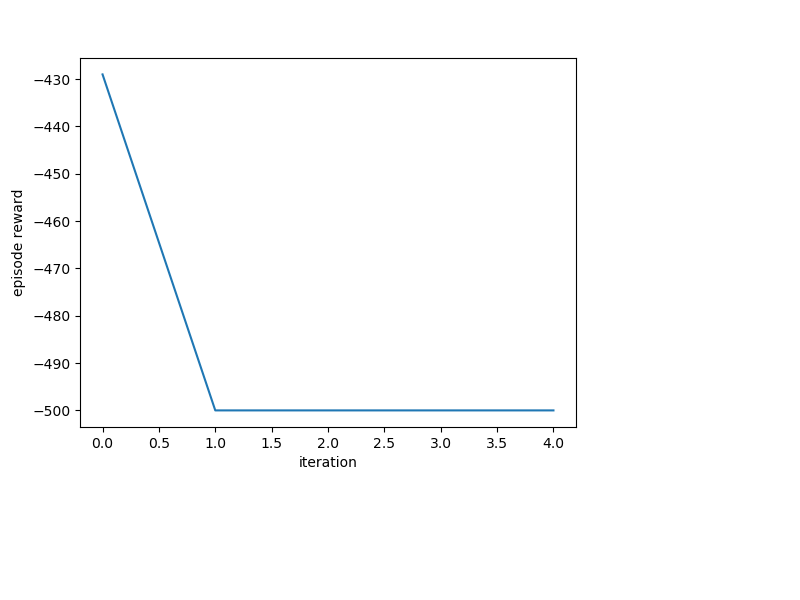

episode 0
episode 1
episode 2
episode 3
episode 4
episode 5


KeyboardInterrupt: 

In [5]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0002}
agent = QActorCriticAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 150
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    print('episode',episode)
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

In [21]:
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

平均回合奖励 = -22074.0 / 100 = -220.74


### 优势执行者/评论者算法

在基本执行者/评论者算法中引入基线函数$B(S_t) = v(S_t;w)$，就会得到$\Psi_t = \gamma^t[q(S_t,A_t;w) - v(S_t;w)]$，其中，$q(S_t,A_t;w) - v(S_t;w)$是优势函数的估计。

采用$q(S_t,A_t;w) - v(S_t;w)$进行优势函数估计，就需要搭建两个目标函数分别表示$q(w),v(w)$，此时采用$U_t = R_{t+1} + \gamma v(S_t;w)$，此时优势函数变为时序差分形式$R_{t+1} + \gamma v(S_{t+1}, w) - v(S_t;w)$

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的参数估计$\pi(\theta)$

【参数】优化器（隐含学习率$\alpha^{(w)},\alpha^{(\theta)}$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$\theta \leftarrow any, w \leftarrow any$
2. 带自益的策略更新：对每个回合执行以下操作
   1. 初始化累积折扣：$I \leftarrow 1$
   2. 决定初始状态动作对：选择状态$S$并用$\pi(\cdot|S;\theta)$得到动作$A$
   3. 若回合未结束执行以下操作：
      1. 采样：根据$S,A$得$S',R$
      2. 执行：用$\pi(\cdot|S;\theta)$得到动作$A'$
      3. 估计回报：$U \leftarrow R+\gamma v(S';w)$
      4. 策略改进：更新$\theta$以减小$-I[U-v(S;w)]\ln\pi(A|S;\theta)$（如$\theta \leftarrow \theta + \alpha^{(\theta)}I[U-v(S;w)]\nabla\ln\pi(A|S;\theta)$）
      5. 更新价值：更新$w$以减小$[U - v(S;w)]^2$（如$w \leftarrow w + \alpha^{(w)}[U - v(S;w)]\nabla v(S;w)$）
      6. 更新累积折扣：$I \leftarrow \gamma I$
      7. 更新状态：$S \leftarrow S'$

---

 若优势执行者/评论者算法在执行过程中**不是每一步都更新参数**，而是**在回合结束后用整个轨迹来进行更新**，就可以把算法分为**经验搜集**和**经验使用**两个部分。这样的分割可以让此算法同时有很多执行者同时执行。*例如，让多个执行者同时分别收集很多经验，然后都用自己的那些经验得到一批经验所带来的梯度更新值。每个执行者在一定时机内更新参数，同时更新策略参数$\theta$和价值参数$w$。*每个执行者的更新是异步的，由此称为**异步优势执行者/评论者算法**（A3C）。异步优势执行者/评论者算法中的自益部分，不仅可采用单步时序差分，也可使用多步时序差分。另外，还可以对函数参数的访问进行控制，使得所有的执行者统一更新参数。这样的算法称为优势执行者/评论者算法。

#### 异步优势执行者/评论者算法实现（某个线程的行为）

【输入】环境（无数学描述）

【输出】最优策略的参数估计$\pi(\theta)$

【参数】优化器（隐含学习率$\alpha^{(w)},\alpha^{(\theta)}$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 同步全局参数：$\theta' \leftarrow \theta, w' \leftarrow w$
2. 逐回合执行以下过程：
   1. 用策略$\pi(\theta')$生成轨迹，知道回合结束或达到上限$T$
   2. 为梯度计算初始化：
      1. 初始化目标$U_T$：若$S_T$是终止状态，则$U \leftarrow 0$；否则$U\leftarrow v(S_t;w')$
      2. 初始化梯度：$g^{(\theta)} \leftarrow 0, g^{(w)} \leftarrow 0$
   3. 异步计算梯度：对$t = T-1, T-2, \dots, 0$执行以下内容：
      1. 估计目标$U_t$：$U \leftarrow \gamma U + R_{t+1}$
      2. 估计策略梯度方向：$g^{(\theta)} \leftarrow g^{(\theta)} + [U - v(S_t;w')]\nabla \ln\pi(A_t|S_t;\theta')$
      3. 估计价值梯度方向：$g^{(w)} \leftarrow g^{(w)} + [U - v(S_t;w')]\nabla v(S_t;w')$
   4. 同步更新：更新全局参数
      1. 策略更新：用梯度方向$g^{(\theta)}$更新策略参数$\theta$（$\theta \leftarrow \theta + \alpha^{(\theta)}g^{(\theta)}$）
      2. 策略更新：用梯度方向$g^{(w)}$更新策略参数$\theta$（$w \leftarrow w + \alpha^{(w)}g^{(w)}$）

In [5]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    step = 0
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        step += 1
        observation = next_observation
    return episode_reward

In [8]:
class AdvantageACAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma = 0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.

        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=tf.losses.categorical_crossentropy,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
    
    def learn(self, state, action, reward, next_state, done):
        x = state[np.newaxis]
        u = reward + (1 - done) * self.gamma * \
            self.critic_net.predict(next_state[np.newaxis])
        td_error = u - self.critic_net.predict(x)
        
        # 训练执行者网络
        x_tensor = tf.convert_to_tensor(x, dtype = tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(x_tensor)[0, action]
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor, 1e-6, 1))
            loss_tensor = -self.discount * td_error * logpi_tensor
        
        grad_tensors = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(zip(
            grad_tensors, self.actor_net.variables))
        
        # 训练评论者网络
        self.critic_net.fit(x, u, verbose = 0)
        
        if done:
            self.discount = 1. # 为下一回合初始化累积折扣
        else:
            self.discount *= self.gamma # 进一步累积折扣

<IPython.core.display.Javascript object>


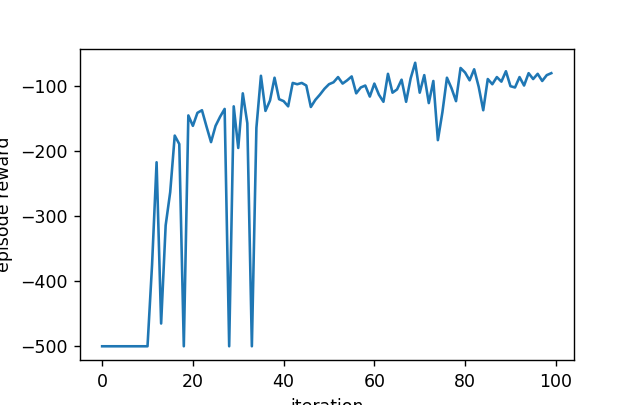

episode: 0, reward: -500.0
episode: 1, reward: -500.0
episode: 2, reward: -500.0
episode: 3, reward: -500.0
episode: 4, reward: -500.0
episode: 5, reward: -500.0
episode: 6, reward: -500.0
episode: 7, reward: -500.0
episode: 8, reward: -500.0
episode: 9, reward: -500.0
episode: 10, reward: -500.0
episode: 11, reward: -375.0
episode: 12, reward: -217.0
episode: 13, reward: -465.0
episode: 14, reward: -314.0
episode: 15, reward: -263.0
episode: 16, reward: -176.0
episode: 17, reward: -189.0
episode: 18, reward: -500.0
episode: 19, reward: -145.0
episode: 20, reward: -161.0
episode: 21, reward: -141.0
episode: 22, reward: -137.0
episode: 23, reward: -162.0
episode: 24, reward: -186.0
episode: 25, reward: -161.0
episode: 26, reward: -147.0
episode: 27, reward: -135.0
episode: 28, reward: -500.0
episode: 29, reward: -131.0
episode: 30, reward: -195.0
episode: 31, reward: -111.0
episode: 32, reward: -157.0
episode: 33, reward: -500.0
episode: 34, reward: -164.0
episode: 35, reward: -84.0
epi

In [9]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0002}

agent = AdvantageACAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    print('episode: {}, reward: {}'.format(episode, episode_reward))
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 带资格迹的执行者/评论者算法

此算法中有两个资格迹$z^{(\theta)}$和$z^{(w)}$，它们分别与策略参数$\theta$，价值参数$w$对应，并可分别有自己的$\lambda^{(\theta)}$和$\lambda^{(w)}$。具体而言，$z^{(w)}$与价值参数$w$对应，运用梯度为$\nabla v(S;w)$，参数为$\lambda^{(w)}$的资格迹；$z^{(\theta)}$与价值参数$w$对应，运用梯度为$\nabla \ln \pi(A|S;w)$，参数为$\lambda^{(\theta)}$的资格迹，在运用中可以将折扣$\gamma^t$整合到资格迹中

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的参数估计$\pi(\theta)$

【参数】资格迹参数$\lambda^{(\theta)}$，$\lambda^{(w)}$，优化器（隐含学习率$\alpha^{(w)},\alpha^{(\theta)}$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$\theta \leftarrow any, w \leftarrow any$

2. 带自益的策略更新：对每个回合执行以下操作：

   1. 初始化资格迹和累积折扣：$z^{(\theta)} \leftarrow 0, z^{(w)} \leftarrow 0, I \leftarrow 1$
   2. 决定初始状态：选择状态$S$
   3. 若回合未结束执行以下操作：
      1. 采样：用$\pi(\cdot|S;\theta)$得到动作$A$
      2. 执行：执行动作$A$，得到奖励$R$和观测$S'$
      3. 估计回报：$U \leftarrow R +\gamma v(S';w)$
      4. 更新策略资格迹：$z^{(\theta)} \leftarrow \gamma \lambda^{(\theta)}z^{(\theta)} + I \nabla\ln\pi(A|S;w)$
      5. 策略改进：$\theta \leftarrow \theta + \alpha^{(\theta)}[U - v(S;w)]z^{(\theta)}$
      6. 更新价值资格迹：$z^{(w)} \leftarrow \gamma \lambda^{(w)}z^{(w)} + \nabla v(S;w)$
      7. 更新价值：$w \leftarrow w + \alpha^{(w)}[U - v(S;w)]z^{w}$
      8. 更新累积折扣$I$：$I \leftarrow \gamma I$
      9. 更新状态$S \leftarrow S'$

In [11]:
class ElibilityTraceACAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma = 0.99,
                actor_lambda = 0.9, critic_lambda = 0.9):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.actor_lambda = actor_lambda
        self.critic_lambda = critic_lambda
        self.gamma = gamma
        self.discount = 1.
        
        self.actor_net = self.build_network(input_size = observation_dim,
                    output_size = self.action_n, output_activation = tf.nn.softmax,
                    **actor_kwargs)
        self.critic_net = self.build_network(input_size = observation_dim,
                    output_size = 1, **critic_kwargs)
        
        self.actor_traces = [np.zeros_like(weight) for weight in self.actor_net.get_weights()]
        self.critic_traces = [np.zeros_like(weight) for weight in self.critic_net.get_weights()]
    
    def learn(self, state, action, reward, next_state, done):
        q =  self.critic_net.predict(state[np.newaxis])[0, 0]
        u = reward + (1 - done) * self.gamma * \
            self.critic_net.predict(next_state[np.newaxis])[0, 0]
        td_error = u - q
        
        # 训练执行者网络
        x_tensor = tf.convert_to_tensor(state[np.newaxis], dtype = tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(x_tensor)
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor, 1e-6, 1.))
            logpi_pick_tensor = logpi_tensor[0, action]
        grad_tensors = tape.gradient(logpi_pick_tensor, self.actor_net.variables)
        self.actor_traces = [self.gamma * self.actor_lambda * trace +
                self.discount * grad.numpy() for trace, grad in
                zip(self.actor_traces, grad_tensors)]
        actor_grads = [tf.convert_to_tensor(-td_error * trace,
                dtype=tf.float32) for trace in self.actor_traces]
        actor_grads_and_vars = tuple(zip(actor_grads,
                self.actor_net.variables))
        self.actor_net.optimizer.apply_gradients(actor_grads_and_vars)
        
        # 训练评论者网络
        with tf.GradientTape() as tape:
            v_tensor = self.critic_net(x_tensor)
        grad_tensors = tape.gradient(v_tensor, self.critic_net.variables)
        self.critic_traces = [self.gamma * self.critic_lambda * trace +
                self.discount* grad.numpy() for trace, grad in
                zip(self.critic_traces, grad_tensors)]
        critic_grads = [tf.convert_to_tensor(-td_error * trace,
                dtype=tf.float32) for trace in self.critic_traces]
        critic_grads_and_vars = tuple(zip(critic_grads,
                self.critic_net.variables))
        self.critic_net.optimizer.apply_gradients(critic_grads_and_vars)
        
        if done:
            # 下一回合重置资格迹
            self.actor_traces = [np.zeros_like(weight) for weight
                    in self.actor_net.get_weights()]
            self.critic_traces = [np.zeros_like(weight) for weight
                    in self.critic_net.get_weights()]
            # 为下一回合重置累积折扣
            self.discount = 1.
        else:
            self.discount *= self.gamma

<IPython.core.display.Javascript object>


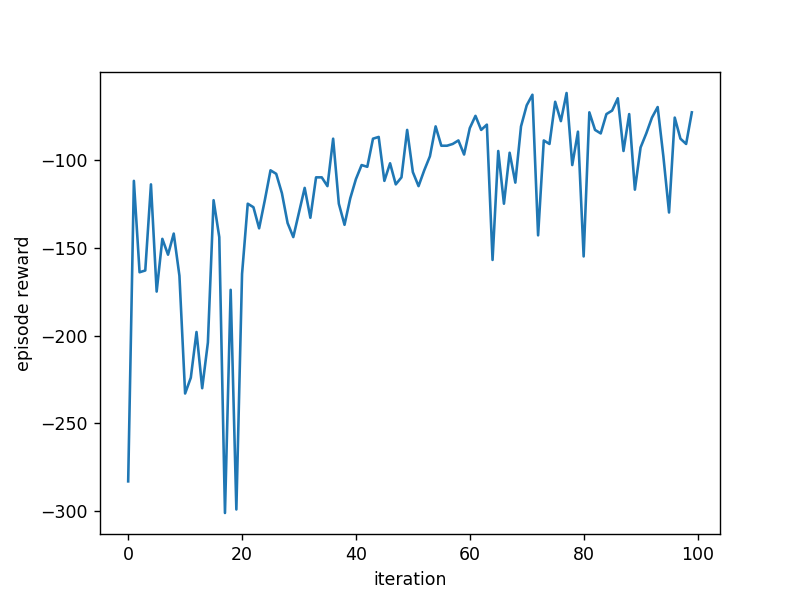

episode: 0, reward: -283.0
episode: 1, reward: -112.0
episode: 2, reward: -164.0
episode: 3, reward: -163.0
episode: 4, reward: -114.0
episode: 5, reward: -175.0
episode: 6, reward: -145.0
episode: 7, reward: -154.0
episode: 8, reward: -142.0
episode: 9, reward: -166.0
episode: 10, reward: -233.0
episode: 11, reward: -224.0
episode: 12, reward: -198.0
episode: 13, reward: -230.0
episode: 14, reward: -204.0
episode: 15, reward: -123.0
episode: 16, reward: -144.0
episode: 17, reward: -301.0
episode: 18, reward: -174.0
episode: 19, reward: -299.0
episode: 20, reward: -165.0
episode: 21, reward: -125.0
episode: 22, reward: -127.0
episode: 23, reward: -139.0
episode: 24, reward: -123.0
episode: 25, reward: -106.0
episode: 26, reward: -108.0
episode: 27, reward: -119.0
episode: 28, reward: -136.0
episode: 29, reward: -144.0
episode: 30, reward: -130.0
episode: 31, reward: -116.0
episode: 32, reward: -133.0
episode: 33, reward: -110.0
episode: 34, reward: -110.0
episode: 35, reward: -115.0
ep

In [13]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0005}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.001}
agent = ElibilityTraceACAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    print('episode: {}, reward: {}'.format(episode, episode_reward))
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

## 基于代理优势的同策算法

* 迭代过程中不直接优化期望目标，而是试图优化期望目标的近似——代理优势

### 代理优势

【**性能差别引理**】$E_{\pi(\theta)}[G_0] = E_{\pi(\theta_k)}[G_0] + E_{\pi(\theta)}\left[ \sum_{t=0}^{+\infty}\gamma^t a_{\pi(\theta_k)}(S_t,A_t) \right]$

（证明思路：化简$E_{\pi(\theta)}\left[ \sum_{t=0}^{+\infty}\gamma^t a_{\pi(\theta_k)}(S_t,A_t) \right]$）

* 要最大化$E_{\pi(\theta)}[G_0]$，就是要最大化优势期望$E_{\pi(\theta)}\left[ \sum_{t=0}^{+\infty}\gamma^t a_{\pi(\theta_k)}(S_t,A_t) \right]$

* 利用重采样将对$A_t\sim\pi(\theta)$求期望转化为对$A_t \sim \pi(\theta_k)$的期望：
  $$
  E_{S_t, A_t\sim\pi(\theta)}[a_\pi(S_t, A_t)] = E_{S_t\sim\pi(\theta), A_t\sim\pi(\theta_k)}\left[\frac{\pi(A_t|S_t;\theta)}{\pi(A_t|S_t;\theta_k)}a_\pi(S_t, A_t)\right]
  $$
  对$S_t\sim\pi(\theta)$求期望无法进一步转化，代理优势则在以上基础下，将对$S_t\sim\pi(\theta)$近似为对$S_t\sim\pi(\theta_k)$求期望：
  $$
  E_{S_t, A_t\sim\pi(\theta)}[a_\pi(S_t, A_t)] \approx E_{S_t, A_t\sim\pi(\theta_k)}\left[\frac{\pi(A_t|S_t;\theta)}{\pi(A_t|S_t;\theta_k)}a_\pi(S_t, A_t)\right]
  $$
  
* 得$E_{\pi(\theta)}[G_0]$近似表达式$l(\theta)$：
  $$
  l(\theta) = E_{\pi(\theta_k)}[G_0] + E_{S_t, A_t\sim\pi(\theta_k)}\left[\sum_{t=0}^{+\infty} \gamma^t \frac{\pi(A_t|S_t;\theta)}{\pi(A_t|S_t;\theta_k)}a_\pi(S_t, A_t)\right]
  $$
  可以证明，$E_{\pi(\theta)}[G_0]$和$l(\theta)$在$\theta = \theta_k$处有相同梯度

由此，通过优化代理优势，有机会改进$E_{\pi(\theta)}[G_0]$，得到更好的策略。

### 邻近策略优化

* 已知代理优势与真实目标相比，在$\theta = \theta_k$处有相同的值和梯度，但是若二者相差较远则近似不再成立。所以针对代理优势的优化不能离原有策略太远

* 邻近策略优化（Proximal Policy Optimization）将优化目标设计为：
  $$
  E\left[
  \min \left( \frac{\pi(A_t|S_t;\theta)}{\pi(A_t|S_t;\theta_k)} a_{\pi(\theta_k)}(S_t,A_t), a_{\pi(\theta_k)}(S_t,A_t) + \varepsilon|a_{\pi(\theta_k)}(S_t,A_t)| \right) \right]
  $$
  其中：$\varepsilon \in(0, 1)$为指定参数，采用这样的优化目标后，优化目标至多比$a_{\pi(\theta_k)}(S_t,A_t)$大$\varepsilon|a_{\pi(\theta_k)}(S_t,A_t)|$，所以优化问题就没有动力让代理优势$\frac{\pi(A_t|S_t;\theta)}{\pi(A_t|S_t;\theta_k)} a_{\pi(\theta_k)}(S_t,A_t)$变得非常大，可以避免迭代后的策略与迭代前的策略差距过大

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略估计$\pi(\theta)$

【参数】策略更新时的限制参数$\varepsilon (\varepsilon > 0)$，优化器，折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$\theta\leftarrow any, w \leftarrow any$
2. 时序差分更新：对每个回合执行以下操作：
   1. 用策略$\pi(\theta)$生成轨迹
   2. 用生成的轨迹由$w$确定的价值函数估计优势函数（如$a(S_t,A_t) \leftarrow \sum_{\tau = t}^{T-1} (\gamma\lambda)^{\tau-t}[U_{\tau:\tau+1}^{(v)} - v(S_t;w)]$）
   3. 策略更新：更新$\theta$以增大$\min \left( \frac{\pi(A_t|S_t;\theta)}{\pi(A_t|S_t;\theta_k)} a_{\pi(\theta_k)}(S_t,A_t), a_{\pi(\theta_k)}(S_t,A_t) + \varepsilon|a_{\pi(\theta_k)}(S_t,A_t)| \right)$
   4. 价值更新：更新$w$以减小价值函数的误差（如最小化$[G - v(S_t;w)]^2$）

在实际应用中往往加入**经验回放**。具体方法：每次更新策略参数和价值参数前得到多个轨迹，为这些轨迹的每一步估计优势和价值目标，并存储在经验库$D$中。接着多次执行以下操作：从经验库中抽取一批经验$B$，并利用这批经验回访并学习，即从经验库中随机抽取一批经验并用这批经验更新策略参数和价值参数

> 邻近策略优化算法在学习过程中使用经验都是当前策略产生的经验，因此仍然是同策学习算法

## 信任域算法

信任域（TRM）是求解非线性问题的常用方法，他将一个复杂的优化问题近似为简单的信任域子问题再进行求解。常见方法如下：

* 自然策略梯度算法
* 信任域策略优化算法
* Kronecker因子信任域执行者/评论者算法

### KL散度

【**定义**】

* 若两个分布$p(x),~q(x)~(x \in \mathscr{X})$，满足对任意的$p(x) > 0$，均有$q(x) > 0$，则称分布$p$对分布$q$绝对连续，记作$p \ll q$

* 在这种情况下，定义从分布$q$到分布$p$的**KL散度**：
  $$
  d_{KL}(p||q) = E_{X\sim p}\left[\ln\frac{p(X)}{q(X)}\right]
  $$
  当分布$p,~q$为离散分布时：
  $$
  d_{KL}(p||q) = \sum_x p(x) \ln \frac{p(x)}{q(x)}
  $$
  当分布$p,~q$为连续分布时：
  $$
  d_{KL}(p||q) = \int_x p(x) \ln \frac{p(x)}{q(x)}\mathrm{d}x
  $$

【**性质**】$d_{KL}(p||p) = 0$

### 信任域

代理优势是回报期望的近似，虽然在$\theta = \theta_k$附近这个近似比较精确，但是在比较远的地方难免会有差别。已经证明：
$$
E_{\pi(\theta)}[G_0] \ge l(\theta) - c \max_s d_{KL}(\pi(·|s;\theta)||\pi(·|s;\theta_k))
$$
其中$c = \frac{4\gamma}{(1-\gamma)^2}\max_{s,a}|a_{\pi(\theta)}(s,a)|$。这个结论说明，用$l(\theta)$来近似得到的误差是有限的，控制好KL散度的大小即可控制近似带来的误差。

从另一个角度看，$l_c(\theta) = l(\theta) - c \max_s d_{KL}(\pi(·|s;\theta)||\pi(·|s;\theta_k))$可以看作是$E_{\pi(\theta)}[G_0]$的一个下界，由于$d_{KL}(\pi(·|s;\theta)||\pi(·|s;\theta_k))$在$\theta = \theta_k$处的值和梯度均为0，所以这个下界依然是$E_{\pi(\theta)}[G_0]$的近似，但是肯定比$E_{\pi(\theta)}[G_0]$小。

在实际应用中，由于最大值的估算十分困难，因此常用KL散度的期望值$\bar{d}_{KL}(\theta||\theta_k) = E_{S\sim \pi(\theta)}[d_{KL}(\pi(·|s;\theta)||\pi(·|s;\theta_k))]$来代替KL散度的最大值。

$\bar{d}_{KL}(\theta||\theta_k)$应该这么理解：在旧的策略$\pi(\theta_k)$下，状态$S_t$是一个随机变量，对于任意的$S_t$的取值，都有该状态下旧策略的动作分布$\pi(·|S_t;\theta_k)$和新策略的动作分布$\pi(·|S_t;\theta)$。这两个分布之间有个KL散度值，这个散度值与$S_t$有关，因此也是随机变量。此随机变量的期望就就是不等式左边的值。KL散度的期望值可以用样本KL散度的平均估计得到。

如果我们要控制$l(\theta)$和$E_{\pi(\theta)}[G_0]$的差别，可以确定一个阈值$\delta$，再让$\bar{d}_{KL}(\theta||\theta_k)$不超过这个阈值$\delta$。这样得到的$\theta$的取值区域$\{\theta:\bar{d}_{KL}(\theta||\theta_k) < \delta\}$称为**信任域**。

KL散度期望可以近似为二次型。在$\theta = \theta_k$处Taylor展开，可以得到：
$$
\bar{d}_{KL}(\theta||\theta_k) = 0 + 0\cdot(\theta - \theta_k) + \frac{1}{2}(\theta - \theta_k)^T F(\theta_k) (\theta - \theta_k)+ \dots
$$
其中$F(\theta)$是Fisher信息矩阵。可以证明，Fisher信息矩阵满足以下等式：
$$
F(\theta) = E_{S,A\sim\theta}[\nabla\ln\pi(A|S;\theta)(\nabla\ln\pi(A|S;\theta))^T]
$$
取$\bar{d}_{KL}(\theta||\theta_k)$的第一个非零项，$\bar{d}_{KL}(\theta||\theta_k)$就可以近似为：
$$
\bar{d}_{KL}(\theta||\theta_k) \approx \frac{1}{2} (\theta - \theta_k)^TF(\theta_k)(\theta - \theta_k)
$$

### 自然梯度算法（NPG）

【**原理**】最大化代理优势并限定新策略处于信任域内来更新策略参数
$$
\begin{aligned}
&\mathrm{maximize} & E_{\pi(\theta_k)}\left[\frac{\pi(A|S;\theta)}{\pi(A|S;\theta_k)}a_{\pi(\theta_k)}(S,A)\right]  \\
&\mathrm{over} &\theta\\
&\mathrm{s.t.} & E_{S\sim \pi(\theta)}[d_{KL}(\pi(·|s;\theta)||\pi(·|s;\theta_k))] \le \delta
\end{aligned}
$$
其中$\delta$为可设置参数。进行进一步简化：

* 对目标函数：$E_{\pi(\theta_k)}\left[\frac{\pi(A|S;\theta)}{\pi(A|S;\theta_k)}a_{\pi(\theta_k)}(S,A)\right] \approx 0 + g(\theta_k)(\theta - \theta_k)$
* 对约束函数：$\bar{d}_{KL}(\theta||\theta_k) \approx \frac{1}{2} (\theta - \theta_k)^TF(\theta_k)(\theta - \theta_k)$

由此得到简化的优化问题：
$$
\begin{aligned}
&\mathrm{maximize} & g(\theta_k)(\theta - \theta_k)  \\
&\mathrm{over} &\theta\\
&\mathrm{s.t.} &\frac{1}{2} (\theta - \theta_k)^TF(\theta_k)(\theta - \theta_k)
\end{aligned}
$$
这个简化问题拥有闭式解：
$$
\theta_{k+1} = \theta_k + \sqrt{ \frac{2\delta}{(g(\theta_k))^TF^{-1}(\theta_k)g(\theta_k)} }F^{-1}(\theta_k)g(\theta_k)
$$
此处的$\sqrt{ \frac{2\delta}{(g(\theta_k))^TF^{-1}(\theta_k)g(\theta_k)} }F^{-1}(\theta_k)g(\theta_k)$被称为**自然梯度**，上式则是NPG的迭代式

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的价值估计$\pi(\theta)$

【参数】KL散度的上界$\delta$，控制轨迹生成和优势函数的参数

1. 初始化：$\theta\leftarrow any, w \leftarrow any$
2. 对每个回合执行以下操作：
   1. 用策略$\pi(\theta)$生成轨迹
   2. 用生成的轨迹估计$\theta$处的策略梯度$g$和FiSher信息矩阵$F$，自然梯度$\sqrt{ \frac{2\delta}{(g(\theta_k))^TF^{-1}(\theta_k)g(\theta_k)} }F^{-1}(\theta_k)g(\theta_k)$
   3. 策略更新：$\theta_{k+1} \leftarrow \theta_k + \sqrt{ \frac{2\delta}{(g(\theta_k))^TF^{-1}(\theta_k)g(\theta_k)} }F^{-1}(\theta_k)g(\theta_k)$
   4. 价值更新：更新$w$以减小价值函数误差

在此迭代式中，需要计算$F^{-1}g$。在参数$\theta$数量特别大的情况下，估计Fisher信息矩阵的逆$F^{-1}$需要大量计算，这种情况下可以利用**共轭梯度法**在不计算$F^{-1}$的情况下直接计算$F^{-1}g$

####  共轭梯度算法（CG）

是一种求解形如$Fx = g$的线性方程组的方法。其中要求系数矩阵$F$为<u>实对称正定矩阵</u>。

【**共轭**】对于两个向量$p_i, p_j$，若它们满足$p_i^T F p_j = 0$，那么称$p_i,p_j$关于$F$共轭。

CG有直接求解法和迭代求解法，以下介绍迭代求解法。

【**核心思想**】$Fx = g$的解为$\frac{1}{2}x^TFx - g^T x$的最小值点。之前求最小值均采用梯度下降方法，从起始点$x_0$开始不断沿着负梯度方向迭代，但是在沿着梯度探索的过程中，不同次迭代方向一般是随机的。对于确定性优化问题没有这种必要，为此，共轭梯度算法每次选择梯度的时候只选择**和之前用过的负梯度方向都共轭的方向**，而且每次都下降到最合适的位置，这样可以尽可能减少迭代次数并找到最优解。

1. 确定迭代方向$p_k$：具体而言，对于第$k$步迭代，在迭代前$x$的取值为$x_k$，这时$\frac{1}{2}x^TFx - g^Tx$的负梯度方向为待求线性方程组的残差$r_k = g - Fx_k$。共轭梯度为了让迭代更高效，需要找到一个和之前用过的方向都共轭的方向。设此方向为：

   $$
   p_k = r_k - \sum_{\kappa = 0}^{k-1}\beta_{k,\kappa} p_\kappa
   $$

   由$p_k^T F p_\kappa = 0~(0 \le \kappa < k)$，可以得到：
   $$
   \beta_{k, \kappa} = \frac{p^T_\kappa F r_\kappa}{p^T_\kappa F p_\kappa}
   $$
   由此确定第$k$次迭代的方向。

2. 确定学习率$\alpha_k$：学习率的选择应当让优化目标$\frac{1}{2}x^TFx - g^T x$在更新后的值$x_{k+1} = x_k + \alpha_k p_k$尽量小。对学习率求偏导，有：
   $$
   \frac{\partial}{\partial \alpha_k} \left( \frac{1}{2}(x_k + \alpha_k p_k)^T F(x_k + \alpha_k p_k) - g^T(x_k + \alpha_k p_k) \right) = \alpha_k p_k^T Fp_k + p_k^T( Fx_k - g)
   $$
   令其为0，有：
   $$
   \alpha_k = \frac{p_k^T(g - Fx_k)}{p_k^T F p_k}
   $$

由此实现梯度迭代算法。

实际应用中可进一步简化运算。定义$\rho_k = r_k^Tr_k,~z_k = Fp_k$。可证：
$$
a_k = \frac{\rho_k}{p_k^Tz_k}, ~r_{k+1} = r_k - \alpha_k z_k,~p_{k+1} = r_{k+1} + \frac{\rho_{k+1}}{\rho_k}p_k
$$
利用以上信息即可实现共轭梯度算法。通过引入小正实数可以提高算法稳定性。

##### 具体实现（共轭梯度算法）

【输入】矩阵$F$和向量$g$

【输出】线性方程组$Fx = g$的解$x$

【参数】迭代次数$n_{CG}$，保持稳定性的参数$\varepsilon > 0$

1. 初始化：设置迭代起点$x \leftarrow any$（常常设置为全0），残差$r = g - Fx$，基底$p = r, \rho = r^Tr$
2. 迭代求解：$k = 1, \dots, n_{CG}$：
   1. $z \leftarrow Fx$
   2. $\alpha \leftarrow \frac{\rho}{p\cdot z + \varepsilon}$
   3. 更新价值和残差：$x \leftarrow x + \alpha p, r \leftarrow r - \alpha z$
   4. 更新基底：$\rho_{新} = r^Tr, p \leftarrow r + \frac{\rho_{新}}{\rho}p$
   5. $\rho \leftarrow \rho_{新}$

#### 带共轭梯度的自然策略算法

【输入】环境（无数学描述）

【输出】最优策略的参数估计$\pi(\theta)$

【参数】共轭梯度法迭代次数$n_{CG}$，KL散度上界$\delta$，控制轨迹生成和估计优势函数的参数

1. 初始化：$\theta\leftarrow any, w\leftarrow any$
2. 对每个回合执行以下操作：
   1. 用策略$\pi(\theta)$生成轨迹
   2. 用生成的轨迹由$w$确定的价值函数估计$\theta$处的策略梯度$g$和优势函数
   3. 用共轭梯度算法迭代$n_{CG}$次得到$x$，计算自然梯度估计$\sqrt{\frac{2\delta}{x^TFx}}x$
   4. 策略更新：更新策略参数$\theta \leftarrow \theta + \sqrt{\frac{2\delta}{x^TFx}}x$
   5. 价值更新：更新$w$以减小价值函数误差

### 信任域策略优化（TRPO）

在自然策略优化的基础上修改而得。在自然梯度算法中，我们试图求解如下问题：
$$
\begin{aligned}
&\mathrm{maximize} & E_{\pi(\theta)} \left[ \frac{\pi(A|S;\theta)}{\pi(A|S;\theta)} a_{\pi(\theta_l)}(S,A) \right]\\
&\mathrm{over} &\theta\\
&\mathrm{s.t.} &E_{S\sim \pi(\theta)}[d_{KL}(\pi(·|s;\theta)||\pi(·|s;\theta_k))]
\end{aligned}
$$
但是自然梯度算法没有直接求解该问题，而是进行简化，求解了一个近似问题。对近似后的优化问题求得最优解，并不一定导致问题又最优解，有时会出现较大偏差。为解决这一问题，信任域策略优化算法将策略参数的迭代式扩展为：
$$
\theta_{k+1} = \theta_k + \alpha^j \sqrt{\frac{2\delta}{[x(\theta_k)]^TF(\theta_k)x(\theta_k)}}x(\theta_k)
$$
其中$\alpha \in  (0, 1)$为学习参数，$j$为某个非负数。对于自然策略梯度，$j$总是为0。信任与策略优化算法用如下方法确定$j$的值：从非负整数到$0,~1,~2,\dots$中<u>依次寻找首个满足期望KL散度约束并且能提升代理梯度的值</u>。一般情况下$j = 0$，极少数情况$j = 1$，其他值几乎没有。

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的参数估计$\pi(\theta)$

【参数】KL散度上界$\delta$，学习率$\alpha$，折扣因子$\gamma$，控制轨迹生成和估计优势函数的参数

1. 初始化：$\theta \leftarrow any, w \leftarrow any$
2. 时序差分更新：对每个回合执行以下操作：
   1. 用策略$\pi(\theta)$生成轨迹
   2. 用生成的轨迹由$w$确定的价值函数估计$\theta$处的策略梯度$g$和优势函数
   3. 用共轭梯度算法迭代$n_{CG}$次得到$x$，计算自然梯度估计$\sqrt{\frac{2\delta}{x^TFx}}x$
   4. 策略更新：确定$j$的值，使得新策略在信任域内，并且代理优势有提升。更新策略参数$\theta \leftarrow \theta + \alpha^j\sqrt{\frac{2\delta}{x^TFx}}x$
   5. 价值更新：更新$w$以减小价值函数误差

### Kronecker因子信任域执行者/评论者算法

【**Kronecker因子近似曲率算法**】（K-FAC）

考虑一个$m$层的全连接神经网络$f:x \mapsto y$，设其第$i$层$(0 \le i < m)$的输入为$x_i$，权重为$W_i$，激活前的输出为$z_i$，则有：
$$
z_i = W_i x_i, 0 \le i < m
$$
最终的输出$y$对网络中所以权重
$$
w = \begin{pmatrix}

\mathrm{vec}(W_0)\\
\mathrm{vec}(W_1)\\
\vdots\\
\mathrm{vec}(W_{m-1})\\
\end{pmatrix}
$$
的梯度可以表示为：
$$
\nabla_w y = \begin{pmatrix} 
\mathrm{vec}(\nabla_{W_0}y)\\
\mathrm{vec}(\nabla_{W_1}y)\\
\vdots\\
\mathrm{vec}(\nabla_{W_{m-1}}y)\\
\end{pmatrix}
$$
考虑任意的$ 0 \le i < m$，由于$z_i = W_ix_i$，用链式法则可知：$\nabla_{W_i}y = g_i x_i^T$，其中$g_i = \nabla_{z_i}y$，进而得出：$\mathrm{vec}(\nabla_{W_i}y) = \mathrm{vec}(g_i x_i^T) = x_i \otimes g_i$

其中$\otimes$为Kronecker积，这里运用了恒等式$\mathrm{vec}(uv^T) = v \otimes u$

再进一步，对于任意的$ 0 \le i, j < m$，有：
$$
\mathrm{vec}(\nabla_{W_i} y)[\mathrm{vec}(\nabla_{W_j} y)] = [x_i \otimes g_i][x_j \otimes g_j]^T = (x_ix_j^T) \otimes (g_ig_j^T)
$$
这里用了恒等式$(A \otimes B)(C \otimes D) = (AC) \otimes (BD)$。这样我们就得到了$(\nabla_W y)(\nabla_W y)^T$的表达式，其中$(i, j)$元素为：
$$
[(\nabla_W y)(\nabla_W y)^T]_{i,j} = (x_ix_j^T) \otimes (g_ig_j^T)
$$
当神经网络的输入为随机变量$X$时：
$$
E[(\nabla_W Y)(\nabla_W Y)^T]_{i,j} = E[(X_iX_j^T)\otimes(G_iG_j^T)] \approx E[X_iX_j^T] \otimes E[G_i G_j^T]
$$
这就是Kronecker因子近似曲率算法的表达式，除了用这样的近似外，还可以进一步将某些$E[(\nabla_WY)(\nabla_WY)^T]$近似为全零矩阵，得到分块对角矩阵或分块三角矩阵

Kronecker因子近似曲率算法可以直接用于Fisher信息矩阵的计算。Fisher信息矩阵具有如下形式：
$$
F = E\left[ [\nabla\ln\pi(A_t|S_t;\theta)] [\nabla\ln\pi(A_t|S_t;\theta)]^T  \right]
$$
上式形式可以用Kronecker因子算法进行处理，可减小计算量。

In [3]:
class PPOReplayer:
    def __init__(self):
        self.memory = pd.DataFrame()
    
    def store(self, df):
        self.memory = pd.concat([self.memory, df], ignore_index = True)
        
    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size = size)
        return (np.stack(self.memory.loc[indices, field]) for field in
               self.memory.columns)

In [12]:
class PPOAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, clip_ratio=0.1,
            gamma=0.99, lambd=0.99, min_trajectory_length=1000,
            batches=1, batch_size=64):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.lambd = lambd
        self.clip_ratio = clip_ratio
        self.min_trajectory_length = min_trajectory_length
        self.batches = batches
        self.batch_size = batch_size
        
        self.trajectory = []
        self.replayer = PPOReplayer()
        
        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
        
    def learn(self, state, action, reward, done):
        self.trajectory.append((state, action, reward))
        
        if done:
            df = pd.DataFrame(self.trajectory, columns=['state',
                    'action', 'reward'])
            states = np.stack(df['state'])
            df['v'] = self.critic_net.predict(states)
            pis = self.actor_net.predict(states)
            df['pi'] = [pi[action] for pi, action in zip(pis, df['action'])]
            
            df['next_v'] = df['v'].shift(-1).fillna(0.)
            df['u'] = df['reward'] + self.gamma * df['next_v']
            df['delta'] = df['u'] - df['v']
            df['return'] = df['reward']
            df['advantage'] = df['delta']
            
            for i in df.index[-2::-1]:
                df.loc[i, 'return'] += self.gamma * df.loc[i + 1, 'return']
                df.loc[i, 'advantage'] += self.gamma * self.lambd * \
                        df.loc[i + 1, 'advantage']
                
            fields = ['state', 'action', 'pi', 'advantage', 'return']
            self.replayer.store(df[fields])
            self.trajectory = []
                
            if len(self.replayer.memory) > self.min_trajectory_length:
                for batch in range(self.batches):
                    states, actions, pis, advantages, returns = \
                            self.replayer.sample(size=self.batch_size)
                    # 训练执行者
                    s_tensor = tf.convert_to_tensor(states, dtype = tf.float32)
                    gather_tensor = tf.convert_to_tensor([(i, a) for i, a
                            in enumerate(actions)], dtype=tf.int32)
                    pi_old_tensor = tf.convert_to_tensor(pis,
                            dtype=tf.float32)
                    advantage_tensor = tf.convert_to_tensor(advantages,
                            dtype=tf.float32)
                    with tf.GradientTape() as tape:
                        all_pi_tensor = self.actor_net(s_tensor)
                        pi_tensor = tf.gather_nd(all_pi_tensor, gather_tensor)
                        surrogate_advantage_tensor = (pi_tensor /
                                pi_old_tensor) * advantage_tensor
                        clip_times_advantage_tensor = self.clip_ratio * \
                                surrogate_advantage_tensor
                        max_surrogate_advantage_tensor = advantage_tensor + \
                                tf.where(advantage_tensor > 0.,
                                clip_times_advantage_tensor,
                                -clip_times_advantage_tensor)
                        clipped_surrogate_advantage_tensor = tf.minimum(
                                surrogate_advantage_tensor,
                                max_surrogate_advantage_tensor)
                        loss_tensor = -tf.reduce_mean(
                                clipped_surrogate_advantage_tensor)
                    actor_grads = tape.gradient(loss_tensor,
                            self.actor_net.variables)
                    self.actor_net.optimizer.apply_gradients(
                            zip(actor_grads, self.actor_net.variables))
        
                    # 训练评论者
                    self.critic_net.fit(states, returns, verbose=0)
                    
                self.replayer = PPOReplayer()

In [6]:
def play_montecarlo(env, agent, render=False, train=False):
    observation = env.reset()
    episode_reward = 0.
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, done)
        if done:
            break
        observation = next_observation
    return episode_reward

<IPython.core.display.Javascript object>


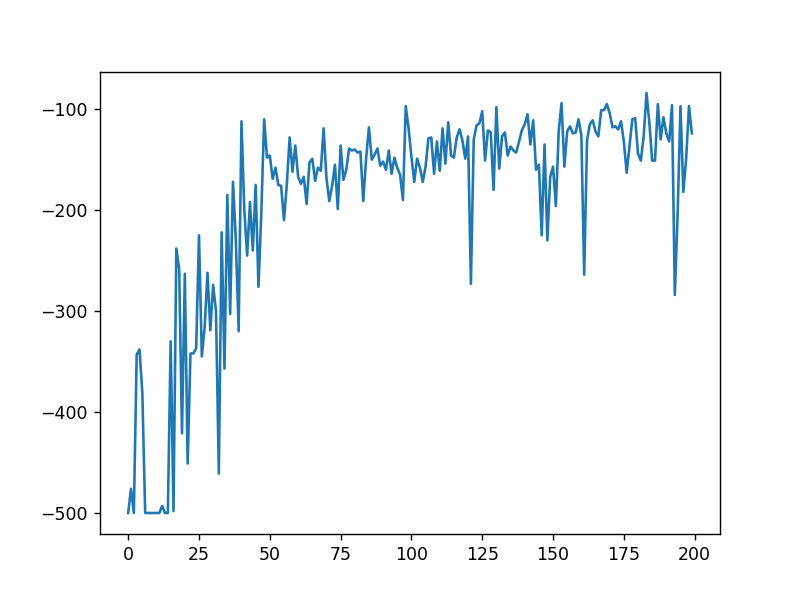

episode: 0, reward: -500.0
episode: 1, reward: -476.0
episode: 2, reward: -500.0
episode: 3, reward: -343.0
episode: 4, reward: -338.0
episode: 5, reward: -381.0
episode: 6, reward: -500.0
episode: 7, reward: -500.0
episode: 8, reward: -500.0
episode: 9, reward: -500.0
episode: 10, reward: -500.0
episode: 11, reward: -500.0
episode: 12, reward: -493.0
episode: 13, reward: -500.0
episode: 14, reward: -500.0
episode: 15, reward: -330.0
episode: 16, reward: -498.0
episode: 17, reward: -238.0
episode: 18, reward: -258.0
episode: 19, reward: -421.0
episode: 20, reward: -263.0
episode: 21, reward: -451.0
episode: 22, reward: -342.0
episode: 23, reward: -342.0
episode: 24, reward: -337.0
episode: 25, reward: -225.0
episode: 26, reward: -345.0
episode: 27, reward: -316.0
episode: 28, reward: -262.0
episode: 29, reward: -319.0
episode: 30, reward: -274.0
episode: 31, reward: -300.0
episode: 32, reward: -461.0
episode: 33, reward: -222.0
episode: 34, reward: -357.0
episode: 35, reward: -185.0
ep

In [14]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.001}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.002}
agent = PPOAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs, batches=50)

# 训练
episodes = 200
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    print('episode: {}, reward: {}'.format(episode, episode_reward))
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

# 测试
episode_rewards = [play_montecarlo(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

## 重要性采样异策执行者/评论者算法

### 基本异策算法

用$b(·|·)$表示行为策略，则梯度方向可以由$E_{\pi(\theta)}[\Psi_t\nabla\ln\pi(A_t|S_t;\theta)]$变为$E_b[\frac{\pi(A_t|S_t;\theta)}{b(A_t|S_t)}\Psi_t\nabla\ln\pi(A_t|S_t;\theta)]$。这时更新策略参数$\theta$时就应该试图减小$-\frac{1}{b(A_t|S_t)}\Psi_t\nabla\pi(A_t|S_t;\theta)$。据此可以得到异策执行者/评论者算法。

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的参数估计$\pi(\theta)$

【参数】优化器（隐含学习率$\alpha^{(\theta)}, \alpha^{(w)}$），折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$\theta \leftarrow any, w \leftarrow any$
2. 带自益的策略更新：对每个回合执行以下操作：
   1. 初始化累积折扣：$I \leftarrow 1$
   2. 初始化状态动作对：选择状态$S$，根据行为策略$b(·|S)$得到动作$A$
   3. 如果回合结束，执行以下操作：
      1. 采样：据状态$S$和动作$A$得到下一时刻状态$S'$
      2. 执行：据$b(·|S')$得到动作$A'$
      3. 估计回报：$U \leftarrow R + \gamma q(S',A';w)$
      4. 策略改进：更新$\theta$以减小$-\frac{1}{b(A_t|S_t)}I\Psi_t\nabla\pi(A_t|S_t;\theta)$（如$\theta \leftarrow \theta + \alpha^{(\theta)}I\frac{1}{b(A_t|S_t)}q(S,A;w)\nabla\pi(A_t|S_t;\theta)$
      5. 更新价值：更新$w$以减小$\frac{\pi(A|S;\theta)}{b(A|S)}[U - q(S,A;w)]^2$（如$w \leftarrow w + \alpha^{(w)}\frac{\pi(A|S;\theta)}{b(A|S)}[U - q(S,A;w)]\nabla q(S,A;w)$
      6. 更新累积折扣：$I \leftarrow \gamma I$
      7. 更新状态：$S \leftarrow S', A \leftarrow A'$

### 带经验回放的异策算法

之前介绍的优势执行者/评论者算法是基于整个轨迹进行更新的。对于引入行为策略和重采样后，对于目标$U_t$的重采样系数变为$\prod_{\tau = 0}^t \rho_\tau$，其中$\rho_\tau = \frac{\pi(A_\tau|S\tau;\theta)}{b(A_\tau|S_\tau)}$。

在次表达式中，每个$\rho_\tau$都有比较大的方差，最终乘积得到的方差会特别大。一种限制方差的方法是<u>控制重采样比例的范围</u>，比如给定一个常数$c$，将重采样的比例截断为$\min\{\rho_\tau, c\}$。但是如果直接将梯度方向中的重采样系数进行截断，会带来偏差。此时可以再加一项弥补此偏差。利用恒等式$\rho = \min\{\rho, c\} + \max\{ \rho - c, 0 \}$。可以把梯度拆为以下两项：

1. $E_b[\min\{\rho_t, c\}\Psi_t\nabla\ln\pi(A_t|S_t;\theta)]$：针对期望策略，此项方程可控
2. $E_b[\max\{ \rho_t - c, 0 \}\Psi_t\nabla\ln\pi(A_t|S_t;\theta)]$即$E_{\pi(\theta)}[\max\{ 1 - \frac{c}{\rho_t}, 0 \}\Psi_t\nabla\ln\pi(A_t|S_t;\theta)]$：采用针对原有目标策略$\pi(\theta)$的期望后，$\max\{ 1 - \frac{c}{\rho_t}, 0\}$也是有界的。（<1)

采用这样的拆分后，两项的方差均可控。但是这两项中一项针对行为策略，一项针对原策略。在执行过程中应当兼顾。

得到梯度方向后，我们对梯度方向进行修正，以免超出范围。为此，用**KL散度**增加约束。记在迭代过程中策略参数的**指数滑动平均值**为$\theta^{EMA}$，对应的平均策略为$\pi(\theta^{EMA})$。我们希望迭代得到的新策略参数不要与这个平均策略$\pi(\theta^{EMA})$参数相差太大。所以可以限定二者在当前状态$S_t$下的动作分布不要差别太大。考虑到KL散度可以直接刻画两个分布的直接差别，所以可以限定新得到的梯度方向（记为$z_t$）与$\nabla_\theta d_{KL}(\pi(·|S_t;\theta^{EMA})||\pi(·|S_t;\theta))$的内积不要太大。值得一提的是，$\nabla_\theta d_{KL}(\pi(·|S_t;\theta^{EMA})||\pi(·|S_t;\theta))$实际上由和重采样比例类似的形式：
$$
\begin{aligned}
&\nabla_\theta d_{KL}(\pi(·|S_t;\theta^{EMA})||\pi(·|S_t;\theta)) \\
&= \nabla_\theta\sum_a\pi(a|S_t;\theta^{EMA})\ln\frac{\pi(a|S_t;\theta^{EMA})}{\pi(a|S_t;\theta)}\\
&= -\nabla_\theta\sum_a\pi(a|S_t;\theta^{EMA})\ln\pi(a|S_t;\theta)\\
&= -\nabla_\theta\sum_a\frac{\pi(a|S_t;\theta^{EMA})}{\pi(a|S_t;\theta)}\nabla_\theta\pi(a|S_t;\theta)
\end{aligned}
$$
因此，我们可以得到一个确定新的梯度方向的优化问题。记新的梯度方向为$z_t$，定义
$$
\begin{aligned}
g_t &= \min\{\rho_t,c\}(U_t - v(S_t;w))\nabla\ln\pi(A_t|S_t;\theta) + \\&E_{A_t\sim\pi(\theta)}\left[\max\{ 1- \frac{\rho_t}{c} \} (q(S_t,A_t;w) - v(S_t;w)) \nabla\ln\pi(A_t|S_t;\theta)  \right]\\
k_t &= \nabla_\theta d_{KL}(\pi(·|S_t;\theta^{EMA})||\pi(·|S_t;\theta))
\end{aligned}
$$
我们一方面希望i虚拟的梯度方向$z_t$和$g_t$尽量接近，另一方面要满足$k^T_tz_t$不超过一个给定参数$\delta$，这样这个问题优化为：
$$
\begin{aligned}
&\mathrm{minimize} &\frac{1}{2}\|g_t - z\|^2_2\\
&\mathrm{over} &z\\
&\mathrm{s.t.} &k_t^Tz_t \le \delta
\end{aligned}
$$
接下来解决此优化问题。使用Lagrange乘子法，构造函数：
$$
l(z,\lambda) = \frac{1}{2}\|g_t - z\|^2_2 + \lambda(k_t^Tz_t - \delta)
$$
令$\frac{\partial l(z, \lambda)}{\partial z}|_{z=z_t;\lambda=\lambda_t} = 0$和$\frac{\partial l(z, \lambda)}{\partial \lambda}|_{z=z_t;\lambda=\lambda_t} = 0$，有：
$$
z_t = g_t - \lambda_t k_t\\
k_t^Tz_t = \delta
$$
将前式代入后式得$\lambda_t = \frac{k_t^Tg_t - \delta}{k_t^Tk_t}$。由于Lagrange乘子应该大于等于0，所以Lagrange乘子应为$\max\{\frac{k_t^Tg_t - \delta}{k_t^Tk_t},0\}$。因此问题的最优解为：
$$
z_t = g_t -\max\{\frac{k_t^Tg_t - \delta}{k_t^Tk_t},0\}k_t
$$
此为确实使用的梯度方向

由此得到带经验回放的异策算法的一个简化版本，此算法有一个回访因子，可以控制每次运行得到的经验，可以回放多少次。

#### 算法实现

【参数】学习率$\alpha^{(\theta)},~\alpha^{(w)}$，指数滑动平均系数$\alpha^{EMA}$，重采样因子截断系数$c$，折扣因子$\gamma$，控制回合数和回合内步数的参数。

1. 同步全局参数：$\theta' \leftarrow \theta,~w' \leftarrow w$
2. 经验回放：回放存储的经验轨迹，以及经验对应的行为策略概率
3. 梯度估计：
   1. 为梯度计算初始化：
      1. 初始化目标$U_T$：若$S_T$是终止状态，则$U \leftarrow 0$，否则$U \leftarrow \sum_a \pi(a|S_t;\theta')$
      2. 初始化梯度：$g^{(w)} \leftarrow 0,~g^{(\theta)} \leftarrow 0$
   2. 异步计算梯度：
      1. 估计目标$U_t$：计算$U \leftarrow R_{t+1} + \gamma U$
      2. 估计价值梯度方向：$g^{(w)} \leftarrow g^{(w)} + [U - q(S_t,A_t;w')]\nabla q(S_t,A_t;w')$
      3. 估计策略梯度方向：计算动作价值$V \leftarrow \sum_a\pi(a|S_t;\theta')q(S_t,a;w')$，重采样系数$\rho \leftarrow \frac{\pi(A_t|S_t;\theta)}{b(A_t|S_t)}$，以及$g,~k \leftarrow \nabla_\theta d_{KL}(\pi(·|S_t;\theta^{EMA})||\pi(·|S_t;\theta)), ~z \leftarrow g -\max\{\frac{k^Tg - \delta}{k^Tk},0\}k, g^{(\theta)} \leftarrow g^{(\theta)}+z$
      4. 更新回溯目标：$U \leftarrow \min\{ \rho, 1 \}[U - q(S_t,A_t;w')] + V$
4. 同步更新：更新全局参数
   1. 价值更新：$w \leftarrow w + \alpha^{(w)}g^{(w)}$
   2. 策略更新：$\theta \leftarrow \theta + \alpha^{(\theta)}g^{(\theta)}$
   3. 更新平均策略：$\theta^{EMA} \leftarrow  (1 - \alpha)\theta^{EMA} + \alpha\theta^{EMA}$

## 柔性执行者/评论者算法

### 熵

【定义】
$$
h(p) = E_{X\sim p}[-\ln p(X)]
$$

* 离散分布：$h(p) = -\sum_x p(x)\ln p(x)$
* 连续分布：$h(p) = -\int_x p(x)\ln p(x)\mathrm{d}x$

对于一个随机变量，不确定性越大，其熵也越大。熵为不确定性的度量。

### 奖励工程和带熵的奖励

【**奖励工程**】通过修改原问题中奖励的定义得到新的强化学习问题，并进行求解，以期为求解原有的强化学习问题提供帮助。

柔性执行者/评论者算法鼓励探索。熵是确定不确定性的度量，熵越大则探索程度越大。为鼓励探索，柔性执行者/评论者算法使用的是带熵的奖励，在原奖励的基础上增加由动作分布确定的熵：
$$
R_{t+1}^{(熵)} = R_{t+1} + \alpha^{(熵)}h(\pi(·|S_t))
$$
其中$\alpha^{(熵)}$是一个参数，后续的带熵奖励对应的强化学习任务的相关量都会带上“熵”的上标。

对于给定的状态动作对$(s,a)$，从状态$s$到动作$a$是完全确定的，不需要为此奖励熵。为此引入一个抛去首个熵的动作价值函数：
$$
q_\pi^{(熵-)}(s,a) = q_\pi^{(熵)}(s,a) -\alpha^{(熵)}h(\pi(·|S_t))
$$
此时：
$$
\begin{aligned}
v_\pi^{(熵)}(s) &= E_{A\sim\pi}[q_\pi^{(熵-)}(s,A) + \alpha^{(熵)}h(\pi(·|S_t))]\\
&= E_{A\sim\pi}[q_\pi^{(熵-)}(s,A) + \alpha^{(熵)}\ln(\pi(A|S_t))]\\
q_\pi^{(熵-)}(s,a) &= q_\pi^{(熵)}(s,a) -\alpha^{(熵)}h(\pi(·|S_t))\\
& = E_\pi[R_{t+1}^{(熵)} + \gamma v_\pi^{(熵)}(S_{t+1})|S_t=s,A_t=a] - \alpha^{(熵)}h(\pi(·|S_t))\\
& = E_\pi[R_{t+1} + \gamma v_\pi^{(熵)}(S_{t+1})|S_t=s,A_t=a]
\end{aligned}
$$
柔性执行者/评论者算法中的评论者将会用到这些带熵的价值函数。

### 网络设计

* 利用含参函数来近似最优价值函数和最优策略。

  为了让算法更稳定，其**分别用不同的含参函数**来近似最优动作价值函数和最优状态价值函数。

  对动作价值函数和状态价值函数的处理也不同：动作价值采用**双重学习**，状态价值采用**目标网络**

* **对动作价值函数近似**：柔性执行者/评论者算法用神经网络近似$q_\pi^{(熵-)}$，并采用与双重Q学习类似的技术，引入两套参数$w^{(0)}$和$w^{(1)}$，用两个形式相同的函数$q(w^{(0)})$和$q(w^{(1)})$来近似$q_\pi^{(熵-)}$。

  双重Q学习可以消除最大偏差，基于查找表的双重Q学习用了两套动作价值函数$q^{(0)}$和$q^{(1)}$，其中一套动作价值函数用来计算最优动作，另外一套用来估计回报。双重Q网络，则考虑到有了目标网络后已经有了两套价值函数的$w$和$w_{目标}$，所以用其中一套参数$w$计算最优动作，再用目标网络的参数$w_{目标}$估计目标。

  对于柔性执行者/评论者算法，它的处理方式与它们都不同。柔性执行者/评论者算法维护两份学习过程的价值网络参数$w^{(i)}$。在估计目标时，选取两个结果中较小的那个，即$\min_{i=0,1} q(·,·;w^{(i)})$

* **对状态价值函数的近似**：采用目标网络，引入两套形式相同的参数$w^{(v)}$和$w^{(v)}_{目标}$，其中$w^{(v)}$是迭代更新日常用的参数，而$w^{(v)}_{目标}$是用来估计目标网络的参数。在更新目标网络时，为了避免参数更新过快，还引入了目标网络学习率$\alpha_{目标}$

综上所述，价值近似一共使用了四套参数：$w^{(0)},~w^{(1)},~w^{(v)},~w^{(v)}_{目标}$。在此基础上，用$q(s,a;w^{(i)})$近似$q_\pi^{(熵-)}(s,a)$，用$v(s;w^{(v)})$近似$v_\pi^{(熵)}(s)$。它们的学习目标如下：

1. 在学习$q(s,a;w^{(i)})$时，试图最小化
   $$
   E_D[(q(S,A;w^{(i)}) - U_t^{(q)})^2]
   $$
   其中目标$U_t^{(q)} = R_{t+1} + \gamma v(S';w_{目标}^{(v)})$

2. 在学习$v(s;w^{(v)})$时，试图最小化
   $$
   E_{S\sim D,A\sim \pi(\theta)}[(v(S;w^{(v)}) - U_t^{(v)})^2]
   $$
   其中目标
   $$
   \begin{aligned}
   U_t^{(v)} &= E_{A'\sim \pi(\theta)}\left[\min_{i=0,1} q(S,A';w^{(i)}) \right] + \alpha^{(熵)}h(\pi(·|S_t))\\
   &= E_{A'\sim \pi(\theta)}\left[\min_{i=0,1} q(S,A';w^{(i)}) - \alpha^{(熵)}\ln\pi(A'|S;\theta) \right] 
   \end{aligned}
   $$
   

3. 在策略近似方面，只用一套参数$\theta$，用$\pi(\theta)$近似最优策略。在学习$\pi(\theta)$时，试图最大化
   $$
   E_{A'\sim\pi(·|S;\theta)}[q(S,A';w^{(0)})]  + \alpha^{(熵)}h(\pi(·|S_t)) =E_{A'\sim \pi(\theta)}\left[\min_{i=0,1} q(S,A';w^{(i)}) - \alpha^{(熵)}\ln\pi(A'|S;\theta) \right]
   $$

由此得到柔性执行者/评论者算法。

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的估计$\pi(\theta)$

【参数】熵的奖励系数$\alpha^{(熵)}$，优化器，折扣因子$\gamma$，控制回合数和回合内步数的参数，目标网络学习率$\alpha_{目标}$

1. 初始化：$\theta \leftarrow any,~w^{(0)},w^{(1)},w^{(v)} \leftarrow any, ~w^{(v)}_{目标} \leftarrow w^{(v)}$

2. 循环执行以下操作：

   1. 累积经验：从状态$S$出发，执行以下操作，直到满足终止条件：

      1. 用策略$\pi(·|S;\theta)$确定动作$A$
      2. 执行动作$A$，观测得到奖励$R$和下一状态$S'$
      3. 将经验$(S,A,R,S')$存储在经验存储空间$D$
      4. 若$S'$是终止状态，则初始化一个新的状态作为$S'$

   2. 更新：在更新的时机，执行一次或多次以下操作：

      1. 经验回放：从存储空间$D$中采样出一批经验$B$

      2. 估计回报：为每条经验$(S,A,R,S') \in B$计算对应的回报$U_t^{(q)} = R_{t+1} +\gamma v(S';w_{目标}^{(v)}),~U_t^{(v)} = E_{A'\sim \pi(\theta)}\left[\min_{i=0,1} q(S,A';w^{(i)}) - \alpha^{(熵)}\ln\pi(A'|S;\theta) \right]$

      3. 价值更新：更新$w^{(i)}$以减小$\frac{1}{|B|}\sum_{(S,A,R,S') \in B}[U_t^{(q)} - q(S,A;w^{(i)})]^2$，更新$w^{(v)}$以减小$\frac{1}{|B|}\sum_{(S,A,R,S') \in B}[U_t^{(v)} - v(S;w^{(v)})]^2$

      4. 策略更新：更新参数$\theta$以减小
         $$
         -\frac{1}{|B|}\sum_{(S,A,R,S') \in B}E_{A'\sim \pi(·|S;\theta)}\left[ q(S,A';w^{(0)}) - \alpha^{(熵)}\ln\pi(A'|S;\theta) \right]
         $$

      5. 更新目标：在恰当时机更新目标网络：$w_{目标}^{(v)} \leftarrow (1 - \alpha_{目标})w_{目标}^{(v)} + \alpha_{目标}w^{(v)}$

补充：
$$
\begin{aligned}
&E_{A'\sim \pi(\theta)}\left[q(S,A';w - \alpha^{(熵)}\ln\pi(A'|S;\theta) \right] \\
&=\sum_{a\in A(S)}\pi(a|S;\theta)[q(S,a;w) -\alpha^{(熵)}\ln\pi(A'|S;\theta) ]
\end{aligned}
$$
在构建网络时，动作价值网络和策略网络往往采用矢量形式的输出，输出维度就是动作空间大小。




In [4]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index = range(capacity),
                    columns = ['state', 'action', 'reward',
                              'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
        
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
    
    def sample(self, size):
        indices = np.random.choice(self.count, size = size)
        return (np.stack(self.memory.loc[indices, field]) for field
               in self.memory.columns)

In [8]:
class SACAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma = 0.99,
                alpha = 0.2, net_learning_rate = 0.1, replayer_capacity = 1000,
                batches = 1, batch_size = 64):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.alpha = alpha
        self.net_learning_rate = net_learning_rate
        
        self.batches = batches
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity)
        
        def sac_loss(y_true, y_pred):
            """ y_true 是 Q(*, action_n), y_pred 是 pi(*, action_n) """
            qs = alpha * tf.math.xlogy(y_pred, y_pred) - y_pred * y_true
            return tf.reduce_sum(qs, axis=-1)
        self.actor_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, output_activation=tf.nn.softmax,
                loss=sac_loss, **actor_kwargs)
        self.q0_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **critic_kwargs)
        self.q1_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **critic_kwargs)
        self.v_evaluate_net = self.build_network(
                input_size=observation_dim, output_size=1, **critic_kwargs)
        self.v_target_net = self.build_network(
                input_size=observation_dim, output_size=1, **critic_kwargs)
        
        self.update_target_net(self.v_target_net, self.v_evaluate_net)
    
    def update_target_net(self, target_net, evaluate_net, learning_rate = 1.):
        target_weights = target_net.get_weights()
        evaluate_weights = evaluate_net.get_weights()
        average_weights = [(1. - learning_rate) * t + learning_rate * e
                for t, e in zip(target_weights, evaluate_weights)]
        target_net.set_weights(average_weights)
    
    def learn(self, state, action, reward, next_state, done):
        self.replayer.store(state, action, reward, next_state, done)
        
        if done:
            for batch in range(self.batches):
                states, actions, rewards, next_states, dones = \
                    self.replayer.sample(self.batch_size)
                pis = self.actor_net.predict(states)
                q0s = self.q0_net.predict(states)
                q1s = self.q1_net.predict(states)
                
                # 训练执行者
                self.actor_net.fit(states, q0s, verbose=0)
                
                # 训练评论者
                q01s = np.minimum(q0s, q1s)
                entropic_q01s = pis * q01s - self.alpha * \
                        scipy.special.xlogy(pis, pis)
                v_targets = entropic_q01s.sum(axis=-1)
                self.v_evaluate_net.fit(states, v_targets, verbose=0)
                
                next_vs = self.v_target_net.predict(next_states)
                q_targets = rewards + self.gamma * (1 - dones) * next_vs[:, 0]
                
                q0s[range(self.batch_size), actions] = q_targets
                q1s[range(self.batch_size), actions] = q_targets
                
                self.q0_net.fit(states, q0s, verbose = 0)
                self.q1_net.fit(states, q1s, verbose = 0)
                
                # 更新目标网络
                self.update_target_net(self.v_target_net,
                        self.v_evaluate_net, self.net_learning_rate)

<IPython.core.display.Javascript object>


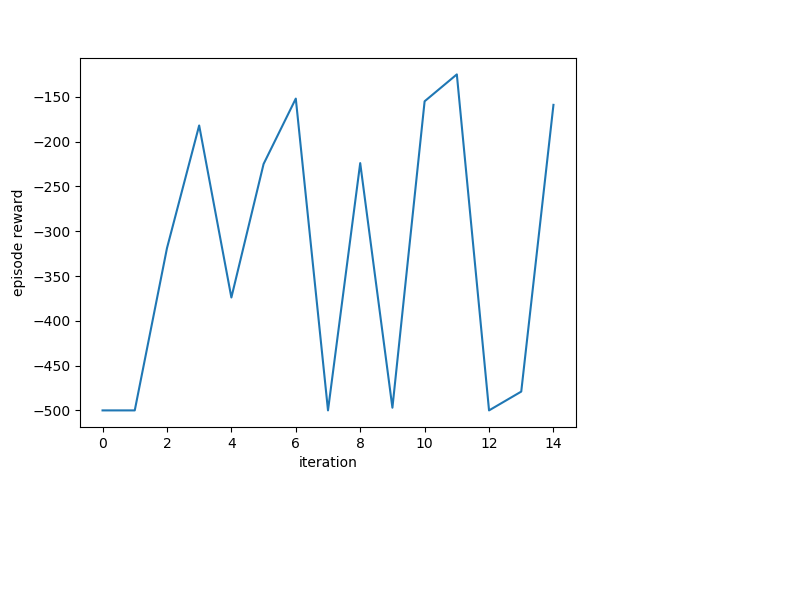

episode: 0, reward: -500.0
episode: 1, reward: -500.0
episode: 2, reward: -319.0
episode: 3, reward: -182.0
episode: 4, reward: -374.0
episode: 5, reward: -225.0
episode: 6, reward: -152.0
episode: 7, reward: -500.0
episode: 8, reward: -224.0
episode: 9, reward: -497.0
episode: 10, reward: -155.0
episode: 11, reward: -125.0
episode: 12, reward: -500.0
episode: 13, reward: -479.0
episode: 14, reward: -159.0


In [ ]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.01}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.01}
agent = SACAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs, batches=50)

# 训练
episodes = 100
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    print('episode: {}, reward: {}'.format(episode, episode_reward))
    episode_rewards.append(episode_reward)    
    chart.plot(episode_rewards)

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))